In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch 
import time
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision.transforms as transforms
from IPython.display import clear_output

In [2]:
import sys
sys.path.append("../pyfiles/")
from util import image_from_output, weights_init, get_target, cuda2numpy
from dataset import get_class_label, FaceDataset
from model import MinMax, SingleGenerator, SingleDiscriminator_original_multi, Encoder_original
from util_notebook import SingleGAN_training, get_output_and_plot

# Introduction
---
In this notebook, we're going to explain the code to experiment with conventional SingleGAN, focusing on the trainig procedure. The results will be examined in `01-test_Conventional_SingleGAN.ipynb`. The main purpose of this notebook is to compare the results between the conventional KL divergence loss and the proposed 3 losses (batch KL divergence loss, correlation loss, histogram imitation loss).


---

# CelebA Dataset
---
In this experiment, I'm gonna use the CelebA dataset, a face dataset that has plenty of annotations. We're therefore able to set various classes or conditions. I explained the details in `A_CelebA_dataset_usage.ipynb`.

---
### Preparation
---
First of all, navigate `root` to the root directory of the dataset and `label_root` to the directory of the label folder. `A_CelebA_dataset_usage.ipynb` also includes how the make the label folder.

---

In [3]:
###############################################
############ adjustable parameters ############

# root = "./../../dataset/celebA/img/"
# label_root = "./../../dataset/celebA/label_folder/"
root = "./../../research/sound_dataset/celebA/img_align_celeba_png/"
label_root = "./../../research/sound_dataset/celebA/label_folder/"

###############################################
###############################################

---
As I said, the CelebA dataset has plenty of annotations, so we need to define which annotation we're gonna use.
There are 3 ways to categorize the usage of the annotations.

- ***existed***: Get the images that belong to the selected annotations.
- ***delete***: Delete the images which belong to the selected annotations.
- ***class***: These annotations are used to compose the classes, \# of classes will be $2^{\#\_classes}$

In this experiment, I used some annotations owing to simplicity and 
set the classes by the use of annotations; "male", "smiling".

---

In [4]:
# 1 5 o clock shadow
# 11 blurry
# 14 chubby
# 15 double chin
# 16 eyeglasses
# 17 goatee
# 21 male
# 23 mustache
# 25 No_Beard
# 31 sideburns
# 32 smiling
# 36 wearing hat
dataset_label = {}
dataset_label["existed"] = [25] 
dataset_label["delete"] = [1, 11, 14, 15, 16, 17, 23, 31, 36] 
dataset_label["class"] = [21, 32] 

In [5]:
label_discription = [
    "male, smiling",
    "male, not smiling",
    "female, smiling",
    "female, not smiling"
]

classes = tuple(range(2**len(dataset_label["class"])))
cl = get_class_label(len(dataset_label["class"]))
classes

(0, 1, 2, 3)

---
### Preprocessing
---
Firstly, The image in the dataset is center-cropped to be the shape (178, 178) and then resized to be the shape (128, 128). In the training process, the random horizontal flip is installed to augment the dataset. When it comes to the value of the image, it's normalized to a range of [-1, 1].


---

In [6]:
transform = {}
transform["train"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    MinMax(True)
])
    
transform["test"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    MinMax(True)
])

---
Let's have a look at some samples of the dataset.

---

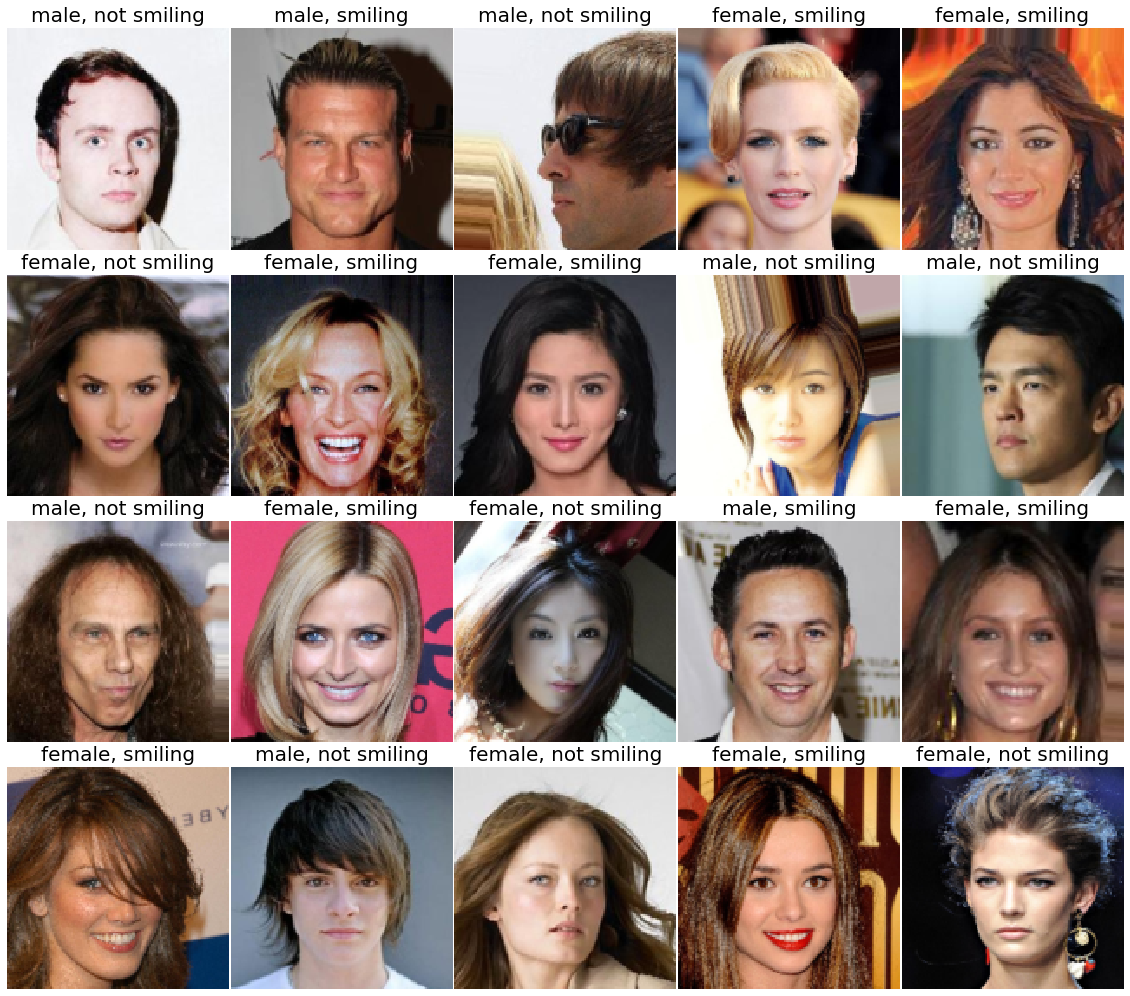

In [7]:
width = 5
length = 4
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=10000, val_num=0, test_num=100)
fig = plt.figure(figsize=(4*width, 4.5*length))
for i in range(width*length):
    ax = fig.add_subplot(length, width, i+1)
    index = np.random.randint(0,len(dataset))
    data = dataset[index]
    img = data[0]
    image = image_from_output(torch.reshape(img, (1,img.shape[0],img.shape[1],img.shape[2])))[0]
    ax.imshow(image)
    ax.set_title(label_discription[data[1]], fontsize=20)
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.03)

# Training
---
Let's train the conventional SingleGAN.

---
### Preparation
---
At first, let's define some parameters for the architecture of the models, including a generator, a discriminator, and an encoder.

---

In [8]:
ndim = 8 # dimension of the latent code for style
nch_in = 3 # the number of channels for input images 

# Hyper-parameters for a generator
nch = 64 # the number of channels for the first convolutional layer
reduce = 2 # image's shape is reduced by a factor of this value
num_cls = 2 # the number of convolutional blocks for compression and expansion
res_num = 6 # the number of residual blocks

# Hyper-parameters for a generator
dis_reduce = 2 # image's shape is reduced by a factor of this value
dis_nch = 64 # the number of channels for the first convolutional layer
dis_num_cls = 4 # the number of convolutional blocks for compression
save_parameter = True # save parameters for the models or not
criterion = nn.MSELoss() # evaluation metrics for discriminator's output
ref_label = np.eye(len(classes)) # class label: one-hot label is employed

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

---
Next, define more detailed information for the models and the lambda parameters for training.

In this notebook, we'll experiment with 2 comparisons:
- conventional KL divergence loss vs. proposed losses
- addition of the concept of UnrolledGAN and regression loss for identity images

Therefore, the adjustable parameters will be:
- `restriction_type`: _"conventionalKL"_ or _"proposedKL"_: employed losses for restriction of the encoder's distribution
- `lbd_idt_reg`: _0_ or _0.5_: regression loss for identity images
- `unrolled_k`: _1_ or _5_: k for UnrolledGAN

---

In [10]:
###############################################
############ adjustable parameters ############

restriction_type = "proposedKL" # "conventionalKL" or "proposedKL": employed losses for restriction of the encoder's distribution
lbd_idt_reg = 0.5 # 0 or 0.5: regression loss for identity images
unrolled_k = 5 # 1 or 5: k for UnrolledGAN

###############################################
###############################################

epoch_num = 31 # the number of epochs
lr_D = 0.0001 # initial learning rate for a Discriminator
lr_G = 0.0002 # initial learning rate for a Generator
lr_E = 0.001  # initial learning rate for an Encoder

if restriction_type == "conventionalKL":
    encoded_feature = "latent" # "latent" or "mu": the encoded features used for regression loss
elif restriction_type == "proposedKL":
    encoded_feature = "mu" # "latent" or "mu": the encoded features used for regression loss

lbd = {}
lbd["cycle"] = 5 # cycle consistency loss
lbd["idt"] = 5 # identity loss
lbd["reg"] = 0.5 # conventional regression loss
lbd["idt_reg"] = lbd_idt_reg # regression loss for indentity images
    
if restriction_type == "conventionalKL":
    lbd["KL"] = 0.1 # conventional KL divergence loss
    lbd["batch_KL"] = 0 # batch KL dvergence loss
    lbd["corr_enc"] = 0 # correlation loss
    lbd["hist"] = 0 # histogram imitation loss
elif restriction_type == "proposedKL":
    lbd["KL"] = 0 # conventional KL divergence loss
    lbd["batch_KL"] = 10 # batch KL dvergence loss
    lbd["corr_enc"] = 100 # correlation loss
    lbd["hist"] = 100 # histogram imitation loss

---
call training and sample dataset. The latter one is used to observe the result while training.

---

In [11]:
###############################################
############ adjustable parameters ############

batch_size = 128

###############################################
###############################################

dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=10000, val_num=0, test_num=100)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
sampleset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=10000, val_num=0, test_num=16)

---
Then, let's call the selected models. In our paper, we exploit multiple GPUs to reduce the training time. You can change the list of GPU you're gonna use.

- `devices`: the list of the GPU's id you will use

---

In [12]:
###############################################
############ adjustable parameters ############

devices = [0,1,2,3]

###############################################
###############################################

netG = SingleGenerator(nch_in, nch, reduce, num_cls, res_num, "instance", num_con=ref_label.shape[1]+ndim).to(device)
netG.apply(weights_init)
netG = nn.DataParallel(netG, devices)
netD = []
for i in classes:
    netD.append(SingleDiscriminator_original_multi(nch_in, dis_nch, dis_reduce, dis_num_cls, "instance").to(device))
    netD[i].apply(weights_init)
    netD[i] = nn.DataParallel(netD[i], devices)
netE = Encoder_original(nch_in, ndim, nch, 4, "instance", ref_label.shape[1], device).to(device)
netE.apply(weights_init)
netE = nn.DataParallel(netE)
sg = SingleGAN_training([netG, netD, netE], [None, None, None], [criterion, None], 
                        lbd, unrolled_k, device, ref_label, ndim, classes, batch_size)
sg.opt_sche_initialization()

---
Let's train your model. Since it takes time to process even just a single epoch, it shows the result 3 times in every epoch.

---

In [ ]:
run_train = True
if run_train:
    interval = int(len(dataset)/batch_size/3) + 2
    losses_D = []
    losses_G = []
    losses_E = []
    for epoch in range(epoch_num):
        start_time = time.time()
        loss_D = []
        loss_G = []
        loss_E = []
        for itr, data in enumerate(dataloader):
            netG.train()
            data_image = data[0]
            data_label = data[1]

            source_image = data_image.to(device)
            label = {}
            label["source"] = data_label.to(device)
            whole_target = get_target(data_label, classes, whole=False)
            label["target"] = torch.tensor(whole_target[:,0], dtype=torch.long, device="cpu")
            errG, errD, errE = sg.train(source_image, label)

            if type(errD)!=int:
                errD = cuda2numpy(errD)
                loss_D.append(errD)
            if type(errG)!=int:
                errG = cuda2numpy(errG)
                loss_G.append(errG)
            if type(errE)!=int:
                errE = cuda2numpy(errE)
                loss_E.append(errE)

            if itr%interval==0:
                if not itr==0:
                    clear_output(wait=True)
                    print(f"epoch {epoch} :itr {itr}/{int(len(dataset)/batch_size)}: {(time.time()-start_time)/60} mins")
                    fig = get_output_and_plot(sg, sampleset, 53, [classes, label_discription], 5, False, device)

                    if not epoch==0:
                        length = 5
                        width = 4
                        losses = [losses_D, losses_G, losses_E]
                        ax = fig.add_subplot(length, width, 17)
                        models = ["Discriminator", "Generator", "Encoder"]
                        for k in range(len(losses)):
                            if models[k] == "Discriminator":
                                if type(losses[k]) == dict:
                                    for i in classes:
                                        ax.plot(losses[k][i], label=f"Discriminator-{i}")
                                elif type(losses[k]) == list:
                                    ax.plot(losses[k], label=f"Discriminator")
                            else:
                                ax.plot(losses[k], label=models[k])
                        ax.legend()
                    plt.show()

        if save_parameter:
            if epoch % 3 == 0:

                torch.save(sg.G.module.state_dict(), f"./instant_model_parameter/gen_conventionalSingleGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_hist{lbd['hist']}_reg{lbd['reg']}_idtreg{lbd['idt_reg']}_unrolledk{unrolled_k}_epoch{epoch}.pth")
                torch.save(sg.E.module.state_dict(), f"./instant_model_parameter/enc_conventionalSingleGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_hist{lbd['hist']}_reg{lbd['reg']}_idtreg{lbd['idt_reg']}_unrolledk{unrolled_k}_epoch{epoch}.pth")
                for i in classes:
                    torch.save(sg.D[i].module.state_dict(), f"./instant_model_parameter/dis-{i}_conventionalSingleGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_hist{lbd['hist']}_reg{lbd['reg']}_idtreg{lbd['idt_reg']}_unrolledk{unrolled_k}_epoch{epoch}.pth")


        for i in classes:
            sg.scheD[i].step()
        losses_D.append(np.mean(loss_D))
        sg.scheG.step()
        losses_G.append(np.mean(loss_G))
        sg.scheE.step()
        losses_E.append(np.mean(loss_E))

        clear_output(wait=True)
        print(f"{epoch+1}: {(time.time()-start_time)/60} mins")
        fig = get_output_and_plot(sg, sampleset, 53, [classes, label_discription], 5, False, device)

        length = 5
        width = 4
        losses = [losses_D, losses_G, losses_E]
        ax = fig.add_subplot(length, width, 17)
        models = ["Discriminator", "Generator", "Encoder"]
        for k in range(len(losses)):
            if models[k] == "Discriminator":
                if type(losses[k]) == dict:
                    for i in classes:
                        ax.plot(losses[k][i], label=f"Discriminator-{i}")
                elif type(losses[k]) == list:
                    ax.plot(losses[k], label=f"Discriminator")
            else:
                ax.plot(losses[k], label=models[k])
        ax.legend()

        plt.show()